# Homework10

Exercises with text processing and NLP modeling

## Goals

- Understand similarities and differences between the processes of working with text, images and tabular data
- Practice with different methods of encoding and modeling text data
- See different methods for extracting information or patterns from text datasets

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/text_utils.py

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from data_utils import display_silhouette_plots, object_from_json_url
from text_utils import get_top_words

You can tell it's gonna be a good homework from the number of imports.
# 🙃

## Have protein, need seasoning

Let's create a model to help us season our foods. In the end, what we want is a model that receives a short list of ingredients and returns a list of seasonings or complementary ingredients for our original ingredients list.

In order to do that we need a dataset of recipes. We'll load that into a text dataset where each recipe is a document and the ingredients are our document *tokens*.

Let's take a look at the recipe dataset and become familiar with the data and how it's organized.

We'll load our recipes and do a bit of exploratory data analysis to look for patterns first to see if this kind of modeling makes any sense.

### Load Data

Here's our dataset. Let's load it into an object for inspection:

In [3]:
DATAPATH = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/refs/heads/main/datasets/text/recipes"
recipes_obj = object_from_json_url(f"{DATAPATH}/recipes_min16.json")

### Look at Data

How's the data organized?

How many recipes do we have?

Do all recipes have the same number of ingredients?

Anything else stand out about the data?

In [5]:
# TODO: Look at Data here
print(f"Shape of recipes_obj: {len(recipes_obj)}")
print(f"First recipe: {recipes_obj[0]}")



# TODO: How many recipes

# TODO: How many ingredients do the shortest and longest recipes have?
# Find recipes with min and max number of ingredients
min_recipe = min(recipes_obj, key=lambda x: len(x['ingredients']))
max_recipe = max(recipes_obj, key=lambda x: len(x['ingredients']))

print("\nRecipe with fewest ingredients:")
print(min_recipe)
print(f"\nNumber of ingredients: {len(min_recipe['ingredients'])}")

print("\nRecipe with most ingredients:")
print(max_recipe) 
print(f"\nNumber of ingredients: {len(max_recipe['ingredients'])}")


Shape of recipes_obj: 5015
First recipe: {'id': 18009, 'ingredients': ['raisins', 'baking powder', 'egg', 'sugar', 'milk', 'flour']}

Recipe with fewest ingredients:
{'id': 47453, 'ingredients': ['salt', 'turmeric', 'rice', 'butter', 'water']}

Number of ingredients: 5

Recipe with most ingredients:
{'id': 36635, 'ingredients': ['guacamole', 'black bean', 'green chile', 'chorizo', 'canola oil', 'lime wedges', 'sour cream', 'hot sauce', 'white cheese', 'lettuce', 'white pepper', 'salt', 'cilantro', 'salsa', 'chicken stock', 'american cheese', 'onion', 'cumin', 'cheddar cheese', 'tortilla', 'corn starch', 'chili', 'radishes', 'garlic', 'avocado', 'cayenne', 'milk']}

Number of ingredients: 27


### Create Input Features

Our dataset doesn't really have to be a `DataFrame` here. It can, but it doesn't have to be.

Each recipe right now is described as a list of ingredients, but what we really want is a list of *sentences*, where each *sentence* is a Python `string` with all of the ingredients for a given recipe.

Instead of:<br>```["salt", "baking soda", "water", "mushroom"]```,

we want:<br>```"salt baking soda water mushroom"```

The `join()` function might help.

Another thing to consider is wether we want to do anything special about multi-word ingredients, like *baking soda*.

Do we want to let our vectorizer (spoiler) split that into two tokens, or do we want to guarantee that *baking* and *soda* always stay together? 

In [8]:
# TODO: turn list of objects into list of strings
# Convert list of ingredients to space-separated strings
recipe_strings = [' '.join(recipe['ingredients']) for recipe in recipes_obj]

print(recipe_strings[0])

# Create new recipes_obj with recipe strings instead of ingredient lists
recipes_obj_strings = []
for i, recipe in enumerate(recipes_obj):
    # Create a copy of the recipe dict and replace ingredients with the string version
    new_recipe = recipe.copy()
    new_recipe['ingredients'] = recipe_strings[i]
    recipes_obj_strings.append(new_recipe)

print("\nFirst recipe with string ingredients:")
print(recipes_obj_strings[0])



raisins baking powder egg sugar milk flour

First recipe with string ingredients:
{'id': 18009, 'ingredients': 'raisins baking powder egg sugar milk flour'}


### Encode Data

The fun part.

Let's vectorize our list of ingredient strings into a sparse document matrix using `CountVectorizer` or `TfidfVectorizer`.

The resulting matrix will have one row for each recipe, and the columns will encode the ingredients.

In [12]:
# TODO: Vectorize ingredients from our recipe list
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the recipe strings
recipe_matrix = vectorizer.fit_transform(recipe_strings)

# Print the shape of the resulting matrix
print(f"Shape of recipe matrix: {recipe_matrix.shape}")

# Print the vocabulary (ingredients)
vocabulary = vectorizer.get_feature_names_out()
print("\nVocabulary (ingredients):")
print(vocabulary)


Shape of recipe matrix: (5015, 464)

Vocabulary (ingredients):
['adobo' 'agave' 'allspice' 'almond' 'amchur' 'american' 'ancho' 'anchovy'
 'andouille' 'angel' 'anise' 'apple' 'apples' 'apricot' 'artichoke'
 'artichokes' 'arugula' 'asafoetida' 'asiago' 'asian' 'asparagus'
 'avocado' 'bacon' 'bags' 'baguette' 'baking' 'bamboo' 'bananas' 'base'
 'basil' 'bay' 'bean' 'beans' 'beansprouts' 'beef' 'beer' 'beets' 'bell'
 'belly' 'bird' 'biscuits' 'black' 'blackberries' 'blueberries' 'boiling'
 'bok' 'bonito' 'bouillon' 'bourbon' 'bow' 'brandy' 'bread' 'breadcrumbs'
 'broccoli' 'broth' 'brown' 'bulb' 'butt' 'butter' 'buttermilk'
 'butternut' 'cabbage' 'cachaca' 'cake' 'cannellini' 'canola' 'capers'
 'caraway' 'cardamom' 'carrots' 'cashew' 'cashews' 'catfish' 'cauliflower'
 'cayenne' 'celery' 'chard' 'cheddar' 'chees' 'cheese' 'cherries'
 'chestnuts' 'chicken' 'chickpeas' 'chile' 'chilees' 'chiles' 'chili'
 'chipotle' 'chipotles' 'chives' 'chocolate' 'chops' 'chorizo' 'choy'
 'chuck' 'cilantro'

### Cluster Data

Now that we have our recipes/documents vectorized we can study them a little bit, and look for patterns.

What happens if we cluster our recipes ? What do the cluster centers represent ?

When might this be useful ?

In [13]:
# TODO: cluster recipes
# Create a KMeans object
kmeans = KMeans(n_clusters=10, random_state=42)

# Fit the KMeans model
kmeans.fit(recipe_matrix)

# Get the cluster assignments for each recipe
recipe_clusters = kmeans.labels_

# Print the number of recipes in each cluster
for i in range(10):
    cluster_size = sum(recipe_clusters == i)
    print(f"Cluster {i}: {cluster_size} recipes")





Cluster 0: 370 recipes
Cluster 1: 597 recipes
Cluster 2: 518 recipes
Cluster 3: 603 recipes
Cluster 4: 365 recipes
Cluster 5: 562 recipes
Cluster 6: 318 recipes
Cluster 7: 672 recipes
Cluster 8: 557 recipes
Cluster 9: 453 recipes


### Cluster Centers

Use the `get_top_words()` function to decode the `cluster_centers` back into ingredients.

In [34]:
# Check shapes
# print("Vocabulary size:", len(vocabulary))
# print("Cluster centers shape:", kmeans.cluster_centers_.shape)

# # kmeans.cluster_centers_

# # For each cluster center
# for i, center in enumerate(kmeans.cluster_centers_):
#     print(f"\nCluster {i}:")
#     # Get the indices of the top 8 values in this center
#     top_indices = center.argsort()[-8:][::-1]
#     # Print the corresponding words and their values
#     for idx in top_indices:
#         print(f"{vocabulary[idx]}: {center[idx]:.4f}")



from text_utils import get_top_words

# TODO: Look at cluster centers
get_top_words(kmeans.cluster_centers_, vocabulary, 8)[0]


[['cheese', 'onion', 'cream', 'tortilla', 'cheddar', 'sour', 'chili', 'salt'],
 ['oil', 'onion', 'garlic', 'salt', 'tomatoes', 'chili', 'olive', 'cumin'],
 ['flour', 'salt', 'egg', 'sugar', 'butter', 'baking', 'milk', 'powder'],
 ['pepper', 'salt', 'black', 'onion', 'butter', 'garlic', 'cheese', 'egg'],
 ['lime', 'juice', 'cilantro', 'onion', 'salt', 'garlic', 'pepper', 'oil'],
 ['sugar', 'water', 'rice', 'sauce', 'egg', 'butter', 'salt', 'onion'],
 ['lemon', 'juice', 'oil', 'olive', 'pepper', 'salt', 'garlic', 'parsley'],
 ['pepper', 'oil', 'salt', 'garlic', 'onion', 'olive', 'black', 'tomatoes'],
 ['sauce', 'oil', 'soy', 'garlic', 'sesame', 'pepper', 'sugar', 'onion'],
 ['cheese', 'oil', 'parmesan', 'olive', 'pepper', 'salt', 'garlic', 'onion']]

### Interpretation

<span style="color:hotpink">
What do these cluster centers represent ?<br>
Is there anything interesting about recipe cluster centers ?<br>
</span>

It looks like it's STARTING to center around different cuisines. There are a couple that could be classified as mexican food, some east asian in nature, another more Italian, and of course baking. 

### Plot Clusters

Let's plot our clusters to see if we have to adjust any of the clustering parameters.

Since we can't plot in $500$ dimensions, we should use `PCA` to look at our clusters in $2D$ and $3D$.

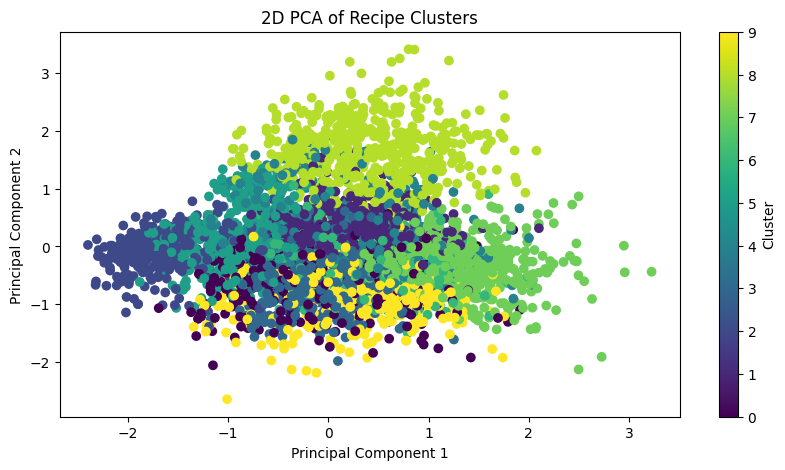

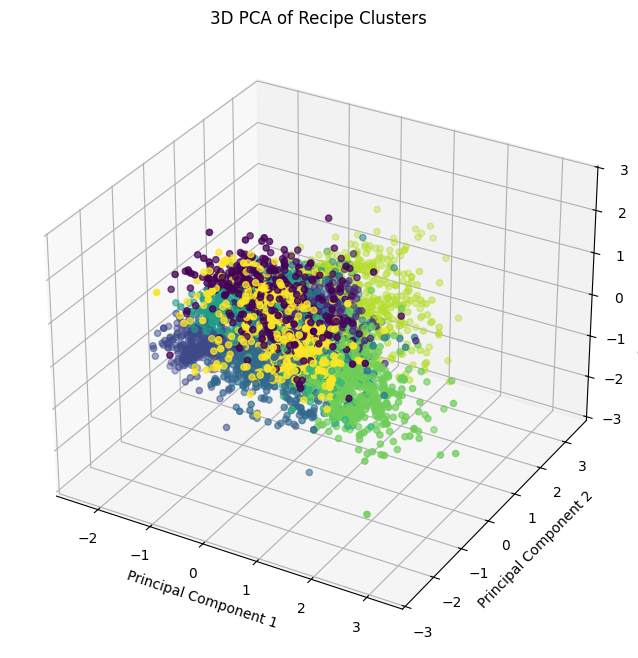

In [36]:
# TODO: PCA to reduce the dimensions of our feature space

pca_2d = PCA(n_components=2).fit_transform(recipe_matrix)
pca_3d = PCA(n_components=3).fit_transform(recipe_matrix)

# Plotting 2D PCA
plt.figure(figsize=(10, 5))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=recipe_clusters, cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Recipe Clusters')
plt.show()

# Plotting 3D PCA
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], c=recipe_clusters, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Recipe Clusters')
plt.show()





# TODO: plot clusters

### Plot Silhouette Plots

We can also check the quality of our clustering by looking at the silhouette plots that we get from calling:<br>
`display_silhouette_plots(vectors, clusters)`.

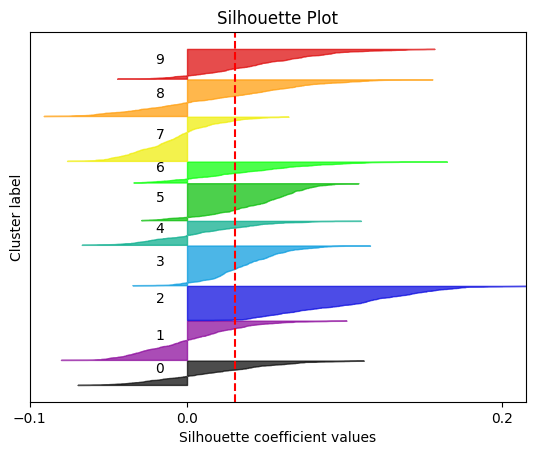

In [38]:
display_silhouette_plots(recipe_matrix, recipe_clusters)

### Interpretation

<span style="color:hotpink">
How many clusters did you end up with ?<br>
How do they look ?<br>
</span>

10 clusters... they look ok! The silhouette plot indicates that most clusters have most of their points effectively clustered... but the best are clusters 2, 5, 6, and 9. The sizing of the clusters isnt even but there arent any seriously significant outliers. 

## Recipe Completion

Ok. On to the main event.

Let's create some recipes.

We'll do this using a technique similar to what is used for movie/product recommendations. Given an initial set of ingredients, we'll look at recipes that have similar ingredients and "recommend" additional ingredients.

We already have all of the recipes in our dataset encoded as `tf-idf` vectors. The rest of our algorithm will be something like:
1. Start with an initial set of ingredients
2. Encode ingredients
3. Find a set of recipes that are similar to our list of ingredients
4. Find common ingredients that are in the similar recipes, but not in our list of ingredients
5. Pick representative ingredient to add to recipe
6. Repeat

Let's start.

### 1. Initial list of ingredients

This is just a string with ingredients:

In [40]:
recipe_seed_str = "sesame onion salt" 

### 2. Encode ingredients

Transform the string into a `tf-idf` vector:

In [45]:
# TODO: transform string into sparse vector

vectorizer = TfidfVectorizer()

recipe_seed_vct = vectorizer.fit_transform([recipe_seed_str])

print(recipe_seed_vct)

  (0, 2)	0.5773502691896258
  (0, 0)	0.5773502691896258
  (0, 1)	0.5773502691896258


### 3. Find similar recipes

The meat of the algorithm. No pun intended.

In order to find similar recipes, we'll first calculate the distance between our current list of ingredients and all recipes in our dataset.

We can start with euclidean distance and later try other kinds, but the overall processing will be the same:

1. Start with an empty list to store distances
2. Loop over the `tf-idf` recipe vectors and for each vector:
   1. Subtract the ingredient list
   2. Square the difference (to square a sparse matrix `A`, use `A.multiply(A)`)
   3. Sum the terms of the result
   4. Take the square root of the sum
   5. Append to distance list
3. Find the indices of the smallest distances (this operation is called `argsort` and will give us the indices of the recipes that are most similar to our list of ingredients)
4. Check the recipes to see if they are indeed similar (`inverse_transform()` the vectors at the indices calculated above)

In [46]:
# argsort a list (get sequence of indices that would sort the list)
# https://stackoverflow.com/a/3382369
def argsort(L, reverse=False):
  return sorted(range(len(L)), key=L.__getitem__, reverse=reverse)

In [53]:
# TODO: list to keep distances
recipe_dists = []

# TODO: loop over vectors and append euclidean distances to list

for i in range(recipe_matrix.shape[0]):
    recipe_dists.append(np.sqrt(np.sum((recipe_matrix[i] - recipe_seed_vct) ** 2)))

# TODO: argsort list of distances to find indices of similar recipes
similar_recipe_idxs = argsort(recipe_dists)

# TODO: check first 4 recipes
print("Most similar recipes:")
for idx in similar_recipe_idxs[:4]:
    print(f"\nRecipe {idx}:")
    print(vectorizer.inverse_transform(recipe_matrix[idx]))



ValueError: inconsistent shapes

### 4. Find ingredients to recommend

We have a way to get a set of similar recipes with similar ingredients, and now want to find a *meaningful*, or *representative*, ingredient to add to our ingredients list.

Let's consider ingredients in the $16$ most similar recipes. What we are trying to do is find an ingredient that is in a lot of these recipes, but not yet in our list of ingredients.

There are many possible ways of doing this. We could count the number of times different ingredients show up in these $16$ recipes using Python dictionaries and/or sets, but what we're trying to do here is very similar to what a `TfidfVectorizer` does: calculate relative importance of terms in a series of documents.

Let's re-encode these $16$ recipes using their own separate `TfidfVectorizer`, then sum the importance of each ingredient and look at ingredients with the highest importance scores.

We could re-use the vectors/scores from the original `TfidfVectorizer`, but they're gonna be influenced by the relative frequencies of all of the ingredients that showed up in all of the recipes. Using a separate vectorizer is a little bit more precise.

The steps we need to take are:

1. Separate the $16$ recipes most similar to our list of ingredients
   1. We have lots of representations of our recipes, but `recipes` (list of strings) might be the easiest one to use here
2. Create a new `TfidfVectorizer` and encode the $16$ recipes
3. Sum the resulting vectors to get overall importance scores for each ingredient/token
4. Convert resulting vector to a list using `A.tolist()[0]`
5. `argsort` the importance scores to get sequence of ingredient indices ordered from most to least important
6. Find the most important ingredient that isn't on the ingredient list

In [ ]:
# TODO: Get 16 most similar recipes

# TODO: Encode the 16 recipes

# TODO: Sum the recipe vectors by column to get ingredient importance scores

# TODO: Convert sparse vector to regular list with A.tolist()[0]

# TODO: argsort the importance scores

# TODO: Find most important ingredient not yet on the list of ingredients

### 5. Add ingredient to recipe

This is simply adding a word to `recipe_seed_str`

In [ ]:
# TODO: add the first important ingredient to list of ingredients

### 6. Repeat (Optional)

Now we can repeat this process until we get an empty list of important ingredients: 
1. Encode current recipe
2. Find similar recipes
3. Find important ingredients
4. Add important ingredient

Might be helpful to define a couple of functions, like `find_similar_recipes()` and `find_important_ingredients()`...

Only do this step if you're really curious about experimenting with generating unconventional ingredient lists. It's not going to be graded.

In [ ]:
# TODO: Create find_similar_recipes(ingredients, recipes, vectorizer)

# TODO: Create find_important_ingredients(recipes)

# TODO: Create recipe by repeating calls to find_similar_recipes() and find_important_ingredients()